In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm

import tensorflow as tf

import os as os
import shutil
from tqdm import tqdm
from random import shuffle

import cv2
from glob import glob

from tensorflow.keras import backend as K
import random
import albumentations as A
from sklearn.model_selection import train_test_split, StratifiedKFold

from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

In [5]:
image_dir = "/content/drive/MyDrive/Dataset/flowers"
filepaths = []
labels = []

for folder in os.listdir(image_dir):
    folder_path = os.path.join(image_dir, folder)
    if os.path.isdir(folder_path):  # Check if it's a directory
        # Get all image files within the folder
        for filename in os.listdir(folder_path):
            if filename.endswith((".jpg", ".jpeg", ".png")):
                filepath = os.path.join(folder_path, filename)
                filepaths.append(filepath)
                labels.append(folder)

# Convert data into pandas DataFrames
filepaths_df = pd.Series(filepaths, name='Filepath')
labels_df = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths_df, labels_df], axis=1)

# Display the DataFrame (optional)
print(image_df.head())

                                            Filepath  Label
0  /content/drive/MyDrive/Dataset/flowers/daisy/1...  daisy
1  /content/drive/MyDrive/Dataset/flowers/daisy/1...  daisy
2  /content/drive/MyDrive/Dataset/flowers/daisy/1...  daisy
3  /content/drive/MyDrive/Dataset/flowers/daisy/1...  daisy
4  /content/drive/MyDrive/Dataset/flowers/daisy/1...  daisy


In [6]:
#Display Tail of the data
image_df.tail()

,Filepath,Label
2741,/content/drive/MyDrive/Dataset/flowers/tulip/9...,tulip
2742,/content/drive/MyDrive/Dataset/flowers/tulip/9...,tulip
2743,/content/drive/MyDrive/Dataset/flowers/tulip/9...,tulip
2744,/content/drive/MyDrive/Dataset/flowers/tulip/9...,tulip
2745,/content/drive/MyDrive/Dataset/flowers/tulip/9...,tulip


In [7]:
#Let's Shuffle the Data of Flowers.
import random

image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/Dataset/flowers/rose/57...,rose
1,/content/drive/MyDrive/Dataset/flowers/sunflow...,sunflower
2,/content/drive/MyDrive/Dataset/flowers/daisy/5...,daisy
3,/content/drive/MyDrive/Dataset/flowers/rose/16...,rose
4,/content/drive/MyDrive/Dataset/flowers/rose/54...,rose


In [8]:
image_df.shape

(2746, 2)

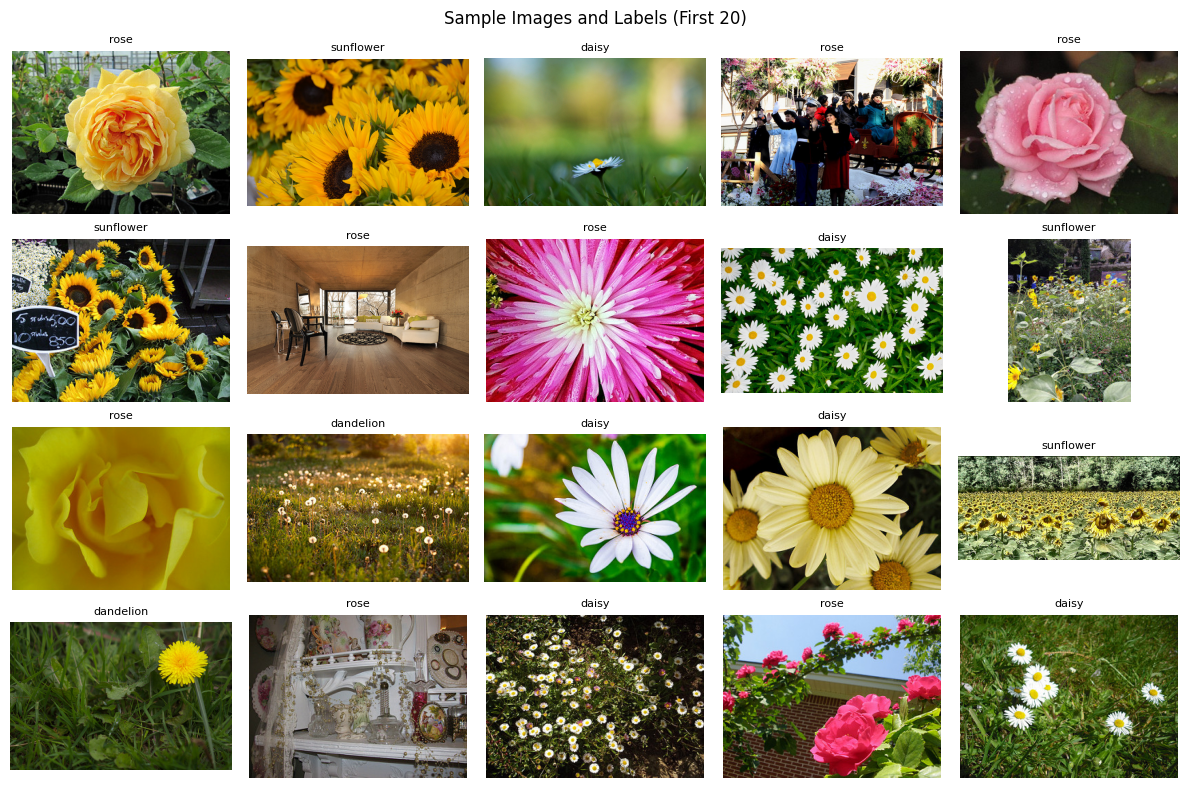

In [9]:
num_images_to_display = 20
image_df_subset = image_df.head(num_images_to_display)

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(12, 8))

# Iterate through the DataFrame subset and display images with labels
for i, row in image_df_subset.iterrows():
    image_path = row['Filepath']
    label = row['Label']
    img = plt.imread(image_path)
  # Display the image and label on the corresponding subplot
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].set_title(label, fontsize=8)
    axes[i // 5, i % 5].axis('off')  # Hide axes for cleaner visualization

fig.suptitle(f"Sample Images and Labels (First {num_images_to_display})", fontsize=12)
plt.tight_layout()

plt.show()

In [10]:
# Split the data into training and testing sets (80% training, 20% testing)
train_df, test_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=42)

# Print the shapes of the training and testing sets
print("Training data shape:", train_df.shape)
print("Testing data shape:", test_df.shape)

Training data shape: (2196, 2)
Testing data shape: (550, 2)


In [11]:
#Train Data Shape
print("Training data shape:", train_df.shape)


Training data shape: (2196, 2)


In [12]:
# MobilenetV2,
# divides the training images into two parts: 80% for training and 20% for validation. The testing images are also preprocessed using
# the same method but are not split.
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [13]:
#Train Data head and tail
train_df.head()

,Filepath,Label
788,/content/drive/MyDrive/Dataset/flowers/rose/50...,rose
2040,/content/drive/MyDrive/Dataset/flowers/tulip/1...,tulip
480,/content/drive/MyDrive/Dataset/flowers/tulip/4...,tulip
900,/content/drive/MyDrive/Dataset/flowers/tulip/7...,tulip
2227,/content/drive/MyDrive/Dataset/flowers/dandeli...,dandelion


In [16]:
train_df.tail()

,Filepath,Label
1638,/content/drive/MyDrive/Dataset/flowers/dandeli...,dandelion
1095,/content/drive/MyDrive/Dataset/flowers/daisy/3...,daisy
1130,/content/drive/MyDrive/Dataset/flowers/rose/57...,rose
1294,/content/drive/MyDrive/Dataset/flowers/daisy/7...,daisy
860,/content/drive/MyDrive/Dataset/flowers/sunflow...,sunflower


In [17]:
#Train,validation and test Data Shape
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1757 validated image filenames belonging to 5 classes.
Found 439 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.


In [18]:
#Creating Model
def create_model(input_shape=(224, 224, 3)):

    inputs = Input(input_shape)
    base_model = EfficientNetB1(input_shape=input_shape, include_top=False, classes=5)

    x = base_model(inputs)

    x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.1)(x)

    x = Dense(56, activation='relu')(x)
    x = Dropout(0.1)(x)

    outputs = Dense(5, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    return model
K.clear_session()

model = create_model((224, 224, 3))
# model = load_model('models/checkpoint/EfficientNetB0.h5')

metrics = [
    'accuracy',
    'AUC'
]

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [19]:
#compiles your created CNN model for training
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=metrics)

In [20]:
#Callbacks
checkpoint_path = 'models/EfficientNetB1/model_224.keras'  # Using .h5 for TensorFlow 2.3.0+

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=False)
]

In [23]:
#Fit Model
import time

start_time = time.time()
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - AUC: 0.9906 - accuracy: 0.9320 - loss: 0.1960 
Epoch 1: saving model to models/EfficientNetB1/model_224.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 841s 15s/step - AUC: 0.9906 - accuracy: 0.9319 - loss: 0.1962 - val_AUC: 0.4990 - val_accuracy: 0.2232 - val_loss: 1.8082 - learning_rate: 0.0010
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - AUC: 0.9925 - accuracy: 0.9499 - loss: 0.1592 
Epoch 2: saving model to models/EfficientNetB1/model_224.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 890s 16s/step - AUC: 0.9925 - accuracy: 0.9499 - loss: 0.1591 - val_AUC: 0.4843 - val_accuracy: 0.2323 - val_loss: 1.7084 - learning_rate: 0.0010
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - AUC: 0.9925 - accuracy: 0.9648 - loss: 0.1434 
Epoch 3: saving model to models/EfficientNetB1/model_224.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 888s 16s/step - AUC: 0.9925 - accuracy: 0.9648 - loss: 0.1433 - val_AUC: 0.6318 - val_accuracy: 0.3166 - val_loss: 3.5997 - learning_rate: 0.

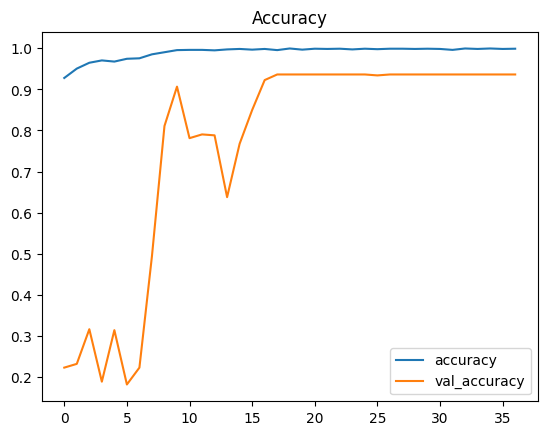

In [24]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

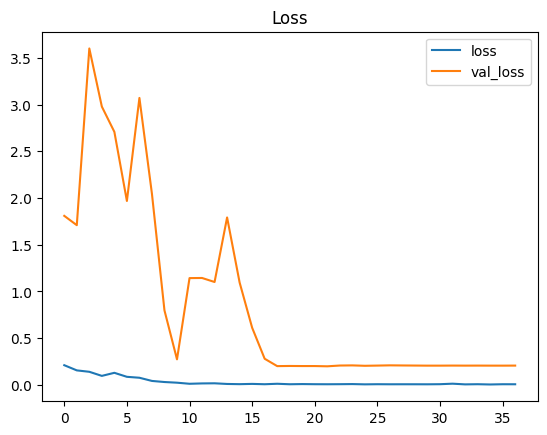

In [25]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [26]:
#Evaluate Model
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.26268
Test Accuracy: 94.00%


In [31]:
# Prediction
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

18/18 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step
The first 5 predictions: ['tulip', 'dandelion', 'dandelion', 'daisy', 'dandelion']


In [32]:
# Classification Report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       daisy       0.98      0.95      0.96        83
   dandelion       0.97      0.96      0.97       146
        rose       0.88      0.93      0.90        99
   sunflower       0.94      0.96      0.95       105
       tulip       0.93      0.90      0.91       117

    accuracy                           0.94       550
   macro avg       0.94      0.94      0.94       550
weighted avg       0.94      0.94      0.94       550



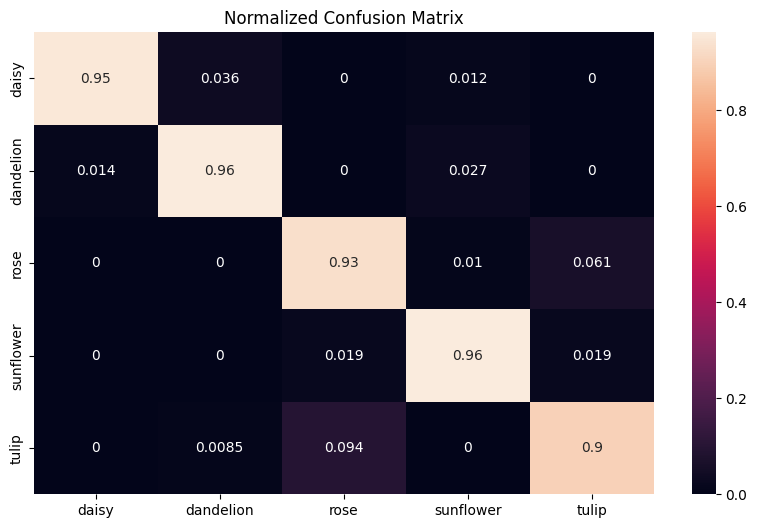

In [33]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()


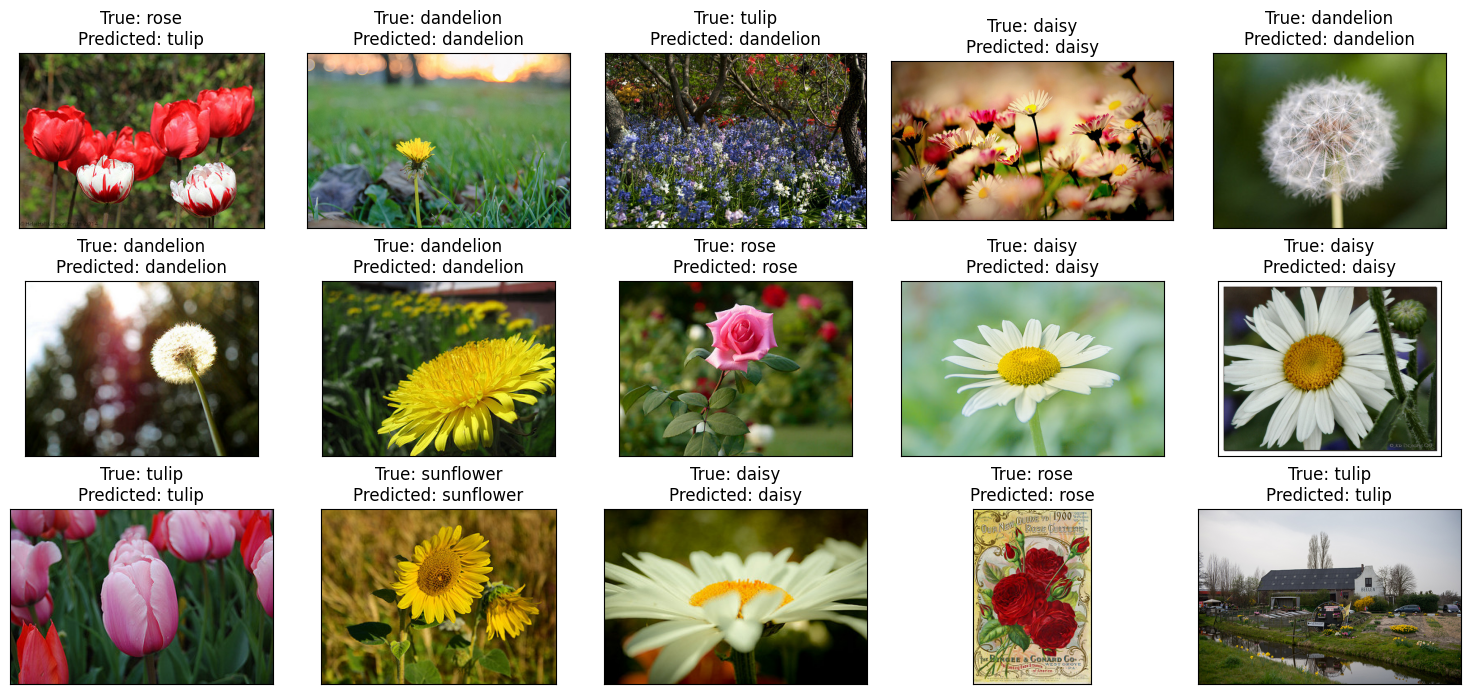

In [34]:
#Vizualize Prediction
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()